### CAPSTONE

### CLEANING DATA AND EXPLORATORY DATA ANALYSIS

#### Lilian Nogueira

In [157]:
# Importing libraries

import rpy2.robjects as robjects
import rpy2.robjects.lib.ggplot2 as ggplot2

#%config InlineBackend.figure_formats = ['svg']
%load_ext rpy2.ipython
#%R require(ggplot2)
%Rdevice png

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from Bio import SeqIO
from collections import defaultdict
import plotly.express as px


import warnings
warnings.filterwarnings('ignore')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [158]:
import os
os.getcwd()

'/home/jovyan/work/files_notebook'

### Cleaning and EDA

The code below will do the following:

   1. Join fasta files (files that contain the viruses aminoacid sequences).
   

   2. Extracting the virus ID from the fasta file and making sure they have the same pattern accross all data.
   

   3. Making sure all sequences have the same size (1040 aminoacids - aa).
   

   4. Some sequences contain consensus symbol #, which means that in the position contaning # could fit any of the following aminoacids: NDQEBZ. This way, I decided to drop those virus sequences for our analyses. Also, removing any sequence that contains * in the middle of the sequence. The * means that in that position there is a stop codon and therefore the virus is defective.

In [159]:
# Using Biopython to join fasta file
path = '.'

data = defaultdict(list)
with open(path + '/virseqs_aa.fasta') as fp:
    for record in SeqIO.parse(fp,"fasta"):
        virus = record.id
        #using regex to have the same virus id's for all tables
        virus = re.sub('.+\..+\..+\.(.+)?\..*','\\1',virus) 
        sequence = str(record.seq)
        # remove stop codon - the stop codon is denoted by an * in the sequence.
        sequence = re.sub(r'\*$','', sequence)
        # check is sequence has 1040 aa
        if len(sequence) > 1040:
            # check if has dash at the end
            if re.search(r'\-$', sequence):
                sequence = re.sub(r'\-$','', sequence)
            else:
                continue
    
        # skip sequence with early stop codon or ambiguity 
        if re.search(r'[\*\#X]', sequence):
            continue
        else:
            data['Virus'].append(virus)
            data['Sequence'].append(sequence)

df_virus = pd.DataFrame.from_dict(data)
df_virus

Virus                                           Sequence
0     ZENV32_0111_5  MRVKE-TQMTWPNF--------WKW--------GTLILG--LVII-...
1     ZENV92_1008_8  MRVKG-TQMNWPNL--------WKW--------GTLILG--LAII-...
2              AE01  MRVKE-TQMNWPNL--------WKW--------GTLILG--LVII-...
3              AE03  MRVKE-TQMNWPNL--------WKW--------GTLILG--LVII-...
4              AE02  MRVKE-TQMNWPNL--------WKW--------GTLILG--LVII-...
...             ...                                                ...
1468          BCF03  MTVT--MKVMEKKN--------RKS--------WILFIV--MASLI...
1469          BCF02  MIVT--MKVMKKKN--------KKLGVS-------LFII--LALII...
1470         BCF108  MTVI--MRAMGKRS--------KKL--------GILYII--MALII...
1471         RBF125  MTVT--MIAMEKKN--------KKS--------WTLYLA--MALLI...
1472         RBF189  MIVT--MKAMEKRN--------RKL--------WNLYIV--MALLI...

[1473 rows x 2 columns]

In [160]:
df_virus.describe()

Virus                                           Sequence
count            1473                                               1473
unique           1473                                               1435
top     ZENV32_0111_5  MRVKG-IRKNWQHL--------WSW--------GMMLLG--MLMI-...
freq                1                                                  8

In [161]:
# Checking dataframe with antibody information stored
df_antibody = pd.read_csv(path + '/abs.txt', sep = "\t")
df_antibody.head()

Name                 Binding Type  \
0            0.5γ  gp120 V3 // V3 glycan (V3g)   
1         10-1074  gp120 V3 // V3 glycan (V3g)   
2       10-1074GM  gp120 V3 // V3 glycan (V3g)   
3  10-1074-IgG3C-  gp120 V3 // V3 glycan (V3g)   
4        10-1074V  gp120 V3 // V3 glycan (V3g)   

                                           Structure Ab patient  \
0                                                NaN     KTS376   
1  4FQ2(10-1074 Fab);EMD-20100(B41 SOSIP.664 in c...   Donor 17   
2                                                NaN   Donor 17   
3                                                NaN   Donor 17   
4                                                NaN   Donor 17   

  Clonal lineage Isolation paper(Pubmed ID)  \
0            NaN   Yoshimura2010(20504942)    
1         PGT121    Mouquet2012a(23115339)    
2         PGT121    Mouquet2012a(23115339)    
3         PGT121   Bournazos2016(27315478)    
4         PGT121                        NaN   

                       Neutralizing antibody feature Light chain type  \
0  Mutations coupling nAb resistance with ceniciv...                K   
1  10-1074 contacts;10-1074 neutralization;10-107...                L   
2                                                NaN              NaN   
3                                                NaN              NaN   
4  hypervariable loop characteristic correlations...              NaN   

   # of viruses tested ADCC  Mean panel IC50  SD panel IC50           Alias  \
0                   43  Yes         26.71270        10.3021  0.5gamma, 1C10   
1                  950  Yes          0.72502        61.5781         10.1074   
2                   26  NaN          1.70613        13.0582             NaN   
3                  119  NaN          1.33043        48.2715             NaN   
4                  201  NaN          0.44827        76.4079             NaN   

         LANL comments  
0                  NaN  
1                  NaN  
2                  NaN  
3  IgG3C hinge variant  
4                  NaN

In [162]:
# Making a list with the column names to make easier to select which ones to keep
column_headers_abs = list(df_antibody)
column_headers_abs

['Name',
 'Binding Type',
 'Structure',
 'Ab patient',
 'Clonal lineage',
 'Isolation paper(Pubmed ID)',
 'Neutralizing antibody feature',
 'Light chain type',
 '# of viruses tested',
 'ADCC',
 'Mean panel IC50',
 'SD panel IC50',
 'Alias',
 'LANL comments']

The columns we are keeping are name of the antibody and binding type.
  - Binding type is the kind of binding the antibody forms with the virus.

The columns being removed below is not needed for our analysis. They are described below:


 - Structure: it contains the kind of 3D antibody structure. There are a lot of information missing and there is no way to input it. Also, it is more important the binding type of the structure for our analysis.
 
 - Ab patient: It is the patient ID from whom the antibody was isolated. Each antibody has a different donor
 
 - Clonal lineage: Upon initial antigen encounter, a naïve B cell (cells that produce antibodies) proliferates and accumulates mutations in the antibody genes that strengthen the antibody-antigen interaction. An antibody clonal lineage is then defined as the population of antibodies encoded by B cells that originate from a single naive B cell. Although genetically similar, individual members of an antibody clonal lineage often display functional differences that are important for a robust antibody response to a pathogen. Members of a clonal lineage are more likely to have a shared antigen specificity than members of different clonal lineages. 
 
 - Isolation paper: scientific publication where rthe antibody was described for the first time.
 
 - Neutralizing antibody feature: This columns contains details from the molecules in the surface of the antibody area that is going to be in contact with the pathogens or toxins. Although is a important feature, this column contains many missing values that we cannot input and the way the information is available is very messy. This way, I decided to remove this column from our analysis. 
 
 
 - Light Chain Type: There are two types of protein chains that make up their structure: heavy chains and light chains. Light chains are smaller proteins that are further classified into two types: kappa (κ) and lambda (λ). The distinction between kappa and lambda light chains is important for classifying different types of antibodies. Like the column Neutralizing antibody feature, there are many missing values that cannot be input.


- ADCC (Antibody-Dependent Cell-Mediated Cytotoxicity): ADCC is an immune mechanism by which certain cells of the immune system, recognize and eliminate target cells that are coated with antibodies. Also, we do not have this information available to all antibodies and there is no way to input it.

- Mean and SD panel IC50: they are the mean and the standard deviation for IC50 from each different experiment.
 

In [163]:
# removing columns
df_antibody.drop(columns =['Structure',
 'Ab patient',
 'Clonal lineage',
 'Isolation paper(Pubmed ID)',
 'Neutralizing antibody feature',
 'Light chain type',
 '# of viruses tested',
 'ADCC',
 'Mean panel IC50',
 'SD panel IC50',
 'Alias',
 'LANL comments'], inplace=True)

df_antibody

Name                                   Binding Type
0              0.5γ                    gp120 V3 // V3 glycan (V3g)
1           10-1074                    gp120 V3 // V3 glycan (V3g)
2         10-1074GM                    gp120 V3 // V3 glycan (V3g)
3    10-1074-IgG3C-                    gp120 V3 // V3 glycan (V3g)
4          10-1074V                    gp120 V3 // V3 glycan (V3g)
..              ...                                            ...
725        VRC-PG20                                    gp120 CD4bs
726              X5                                     gp120 CD4i
727            Y498                                    gp120 CD4bs
728             Z13  gp41 MPER (membrane proximal external region)
729           Z13e1  gp41 MPER (membrane proximal external region)

[730 rows x 2 columns]

In [164]:
df_antibody.describe()

Name Binding Type
count    730          645
unique   730           48
top     0.5γ  gp120 CD4bs
freq       1          188

In [165]:
# Renaming column to have the same columns name across all data
df_antibody.rename(columns ={'Name': 'Antibody'}, inplace=True)
df_antibody.head()

Antibody                 Binding Type
0            0.5γ  gp120 V3 // V3 glycan (V3g)
1         10-1074  gp120 V3 // V3 glycan (V3g)
2       10-1074GM  gp120 V3 // V3 glycan (V3g)
3  10-1074-IgG3C-  gp120 V3 // V3 glycan (V3g)
4        10-1074V  gp120 V3 // V3 glycan (V3g)

In [166]:
# loading assay data
df_assay = pd.read_csv(path + '/assay.txt', sep = "\t")
df_assay

Antibody        Virus  \
0                0.5γ       6535_3   
1                0.5γ         89_6   
2                0.5γ      AC10_29   
3                0.5γ       BAL_01   
4                0.5γ     CAAN5342   
...               ...          ...   
135683  VRC26.25+iMab     DU156_12   
135684  VRC26.25+iMab      DU422_1   
135685  VRC26.25+iMab        PVO_4   
135686  VRC26.25+iMab  X2278_C2_B6   
135687  VRC26.25+iMab      ZM53_12   

                                            Reference   Pubmed ID     IC50  \
0       Ramirez Valdez et al. Virology 475:187 (2015)  25486586.0      0.3   
1       Ramirez Valdez et al. Virology 475:187 (2015)  25486586.0     <.05   
2       Ramirez Valdez et al. Virology 475:187 (2015)  25486586.0      110   
3       Ramirez Valdez et al. Virology 475:187 (2015)  25486586.0     <.05   
4       Ramirez Valdez et al. Virology 475:187 (2015)  25486586.0       80   
...                                               ...         ...      ...   
135683    Moshoette et al. Retrovirology 16:31 (2019)  31703699.0  0.01129   
135684    Moshoette et al. Retrovirology 16:31 (2019)  31703699.0   0.0132   
135685    Moshoette et al. Retrovirology 16:31 (2019)  31703699.0  0.05204   
135686    Moshoette et al. Retrovirology 16:31 (2019)  31703699.0  0.00916   
135687    Moshoette et al. Retrovirology 16:31 (2019)  31703699.0   0.0021   

       IC80 ID50  
0       NaN  NaN  
1       NaN  NaN  
2       NaN  NaN  
3       NaN  NaN  
4       NaN  NaN  
...     ...  ...  
135683  NaN  NaN  
135684  NaN  NaN  
135685  NaN  NaN  
135686  NaN  NaN  
135687  NaN  NaN  

[135688 rows x 7 columns]

In [167]:
# Making a list with the column names to make easier to select which ones to keep
column_headers_assay = list(df_assay)
column_headers_assay

['Antibody', 'Virus', 'Reference', 'Pubmed ID', 'IC50', 'IC80', 'ID50']

We are keeping antibody, Virus and IC50. 

IC50 is  half maximal inhibitory concentration (IC50) is a measure of the potency of a substance in inhibiting a specific biological or biochemical function. IC50 is a quantitative measure that indicates how much of a particular inhibitory substance is needed to inhibit a given biological process or biological component by 50%. Lower values of IC50 means more potent inhibitory action.

In [168]:
#dropping columns that are not going to be used
df_assay.drop(columns =['Reference', 'Pubmed ID', 'IC80', 'ID50'], inplace=True)
df_assay

Antibody        Virus     IC50
0                0.5γ       6535_3      0.3
1                0.5γ         89_6     <.05
2                0.5γ      AC10_29      110
3                0.5γ       BAL_01     <.05
4                0.5γ     CAAN5342       80
...               ...          ...      ...
135683  VRC26.25+iMab     DU156_12  0.01129
135684  VRC26.25+iMab      DU422_1   0.0132
135685  VRC26.25+iMab        PVO_4  0.05204
135686  VRC26.25+iMab  X2278_C2_B6  0.00916
135687  VRC26.25+iMab      ZM53_12   0.0021

[135688 rows x 3 columns]

In [169]:
df_assay.describe()

Antibody   Virus    IC50
count    135688  135688  132221
unique      749    1803    8855
top       VRC01  TRO_11     >50
freq       6477    1244   33697

In [170]:
# Combining all the data frames 

df_all = pd.merge(pd.merge(df_assay,df_antibody,how='outer', on='Antibody'),df_virus, how='outer', on='Virus')
df_all

Antibody         Virus   IC50                 Binding Type  \
0          0.5γ        6535_3    0.3  gp120 V3 // V3 glycan (V3g)   
1       10-1074        6535_3  0.001  gp120 V3 // V3 glycan (V3g)   
2       10-1074        6535_3  0.013  gp120 V3 // V3 glycan (V3g)   
3       10-1074        6535_3  0.001  gp120 V3 // V3 glycan (V3g)   
4       10-1074        6535_3  0.014  gp120 V3 // V3 glycan (V3g)   
...         ...           ...    ...                          ...   
135721      NaN     BJYA180_8    NaN                          NaN   
135722      NaN     BJYA187_8    NaN                          NaN   
135723      NaN     BJYA192_4    NaN                          NaN   
135724      NaN     BJYA194_5    NaN                          NaN   
135725      NaN  CAP45_CS_MUT    NaN                          NaN   

                                                 Sequence  
0       MKVKG-TRKNYQRL--------WRW--GNM---LTMLLG--MLMI-...  
1       MKVKG-TRKNYQRL--------WRW--GNM---LTMLLG--MLMI-...  
2       MKVKG-TRKNYQRL--------WRW--GNM---LTMLLG--MLMI-...  
3       MKVKG-TRKNYQRL--------WRW--GNM---LTMLLG--MLMI-...  
4       MKVKG-TRKNYQRL--------WRW--GNM---LTMLLG--MLMI-...  
...                                                   ...  
135721  MRVKG-IRKNCQHW--------LTW--------GMMLLG--TLII-...  
135722  MRVME-TRKSCQHW--------LTW--------GTMLFG--MLMI-...  
135723  MRVKG-TRKNCQHW--------LTW--------VTMLLG--MLMI-...  
135724  MIVMG-IRKNCQHW--------LTW--------GTMLLG--MLMI-...  
135725  MRVRG-ILRNWPQW--------WIW--------SILGFW--MLII-...  

[135726 rows x 5 columns]

In [171]:
# Dropping rows with missing values for IC50, sequence and binding type
# IC50 is going to be our target variable. It is the threshold for virus neutralization
# Binding type is a important feature for virus neutralization and we can not impute missing values
# We cannot impute sequences as well
df_all = df_all.dropna(subset = ['IC50', 'Sequence', 'Binding Type'])
df_all

Antibody           Virus   IC50                 Binding Type  \
0           0.5γ          6535_3    0.3  gp120 V3 // V3 glycan (V3g)   
1        10-1074          6535_3  0.001  gp120 V3 // V3 glycan (V3g)   
2        10-1074          6535_3  0.013  gp120 V3 // V3 glycan (V3g)   
3        10-1074          6535_3  0.001  gp120 V3 // V3 glycan (V3g)   
4        10-1074          6535_3  0.014  gp120 V3 // V3 glycan (V3g)   
...          ...             ...    ...                          ...   
135681  VRC-PG05  254001_P00RA_1    >50            gp120 silent face   
135682  VRC-PG05  254004_P00RC_2  0.265            gp120 silent face   
135683  VRC-PG05  254006_P00RA_1    >50            gp120 silent face   
135684  VRC-PG05   40061_V03_04B    >50            gp120 silent face   
135686  VRC-PG05     644039_C01B    >50            gp120 silent face   

                                                 Sequence  
0       MKVKG-TRKNYQRL--------WRW--GNM---LTMLLG--MLMI-...  
1       MKVKG-TRKNYQRL--------WRW--GNM---LTMLLG--MLMI-...  
2       MKVKG-TRKNYQRL--------WRW--GNM---LTMLLG--MLMI-...  
3       MKVKG-TRKNYQRL--------WRW--GNM---LTMLLG--MLMI-...  
4       MKVKG-TRKNYQRL--------WRW--GNM---LTMLLG--MLMI-...  
...                                                   ...  
135681  MRVKE-TQMSWPNL--------WRW--------GTLILG--LVII-...  
135682  MRVKE-TQMTWPNF--------WKW--------GTLILG--LVIM-...  
135683  MRVKE-TQTNWPNL--------WKW--------GTLILG--LVII-...  
135684  MRVKE-IQMNWPNL--------WKW--------GTLILG--LVII-...  
135686  MRVKE-TQMNWPNL--------WKW--------GTLILG--LVII-...  

[113358 rows x 5 columns]

In [172]:
df_all.isna().sum()

Antibody        0
Virus           0
IC50            0
Binding Type    0
Sequence        0
dtype: int64

In [173]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113358 entries, 0 to 135686
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Antibody      113358 non-null  object
 1   Virus         113358 non-null  object
 2   IC50          113358 non-null  object
 3   Binding Type  113358 non-null  object
 4   Sequence      113358 non-null  object
dtypes: object(5)
memory usage: 5.2+ MB


In [174]:
# Checking the data type that are contained in columns IC50

type(df_all['IC50'][1])

str

In [175]:
# Using regex to remove the characters > and < and to convert string to numeric data

df_all['IC50'] = pd.to_numeric(df_all['IC50'].str.replace('[<>]','', regex=True))
df_all

Antibody           Virus    IC50                 Binding Type  \
0           0.5γ          6535_3   0.300  gp120 V3 // V3 glycan (V3g)   
1        10-1074          6535_3   0.001  gp120 V3 // V3 glycan (V3g)   
2        10-1074          6535_3   0.013  gp120 V3 // V3 glycan (V3g)   
3        10-1074          6535_3   0.001  gp120 V3 // V3 glycan (V3g)   
4        10-1074          6535_3   0.014  gp120 V3 // V3 glycan (V3g)   
...          ...             ...     ...                          ...   
135681  VRC-PG05  254001_P00RA_1  50.000            gp120 silent face   
135682  VRC-PG05  254004_P00RC_2   0.265            gp120 silent face   
135683  VRC-PG05  254006_P00RA_1  50.000            gp120 silent face   
135684  VRC-PG05   40061_V03_04B  50.000            gp120 silent face   
135686  VRC-PG05     644039_C01B  50.000            gp120 silent face   

                                                 Sequence  
0       MKVKG-TRKNYQRL--------WRW--GNM---LTMLLG--MLMI-...  
1       MKVKG-TRKNYQRL--------WRW--GNM---LTMLLG--MLMI-...  
2       MKVKG-TRKNYQRL--------WRW--GNM---LTMLLG--MLMI-...  
3       MKVKG-TRKNYQRL--------WRW--GNM---LTMLLG--MLMI-...  
4       MKVKG-TRKNYQRL--------WRW--GNM---LTMLLG--MLMI-...  
...                                                   ...  
135681  MRVKE-TQMSWPNL--------WRW--------GTLILG--LVII-...  
135682  MRVKE-TQMTWPNF--------WKW--------GTLILG--LVIM-...  
135683  MRVKE-TQTNWPNL--------WKW--------GTLILG--LVII-...  
135684  MRVKE-IQMNWPNL--------WKW--------GTLILG--LVII-...  
135686  MRVKE-TQMNWPNL--------WKW--------GTLILG--LVII-...  

[113358 rows x 5 columns]

In [176]:
unique_antibodies = len(np.unique(df_all["Antibody"]))
print("Number of Unique Antibodies:", unique_antibodies)

Number of Unique Antibodies: 614


In this dataset, sometimes we have different values of IC50 for the same pair of Antibody and Virus tested. This happens because different laboratories tested the same pairs. In these cases, I calculated the average IC50 and inputed the average for the repeated pairs and dropped the duplicates.

In [177]:
# IC50 average per antibody and virus
df_ic50 = df_all.groupby(by=['Antibody', 'Binding Type', 'Virus', 'Sequence'], as_index=False).mean()
df_ic50

Antibody                 Binding Type      Virus  \
0         0.5γ  gp120 V3 // V3 glycan (V3g)     6535_3   
1         0.5γ  gp120 V3 // V3 glycan (V3g)       89_6   
2         0.5γ  gp120 V3 // V3 glycan (V3g)    AC10_29   
3         0.5γ  gp120 V3 // V3 glycan (V3g)   CAAN5342   
4         0.5γ  gp120 V3 // V3 glycan (V3g)  CAP210_E8   
...        ...                          ...        ...   
57307  vFP7.05           gp41 fusion domain    ZM215_8   
57308  vFP7.05           gp41 fusion domain    ZM233_6   
57309  vFP7.05           gp41 fusion domain    ZM249_1   
57310  vFP7.05           gp41 fusion domain    ZM53_12   
57311  vFP7.05           gp41 fusion domain   ZM55_28A   

                                                Sequence    IC50  
0      MKVKG-TRKNYQRL--------WRW--GNM---LTMLLG--MLMI-...    0.30  
1      MRVKE-IRKNWQHL---------RG--------GILLLG--MLMI-...    0.05  
2      MRVRE-TRKNYQHLW-------WKW--------GMMLLG--MLMI-...  110.00  
3      MRVKE-IRKNYRHL--------WKW--------GIMLLG--MLMI-...   80.00  
4      MRVMG-IQRNWQQW--------GIW--------GILGFW--LLMI-...  150.00  
...                                                  ...     ...  
57307  MRVMG-ILRNCQQW--------WIW--------GILGFW--MI---...  100.00  
57308  MRVRG-IMRNWQQW--------WIW--------GSLGFW--MLII-...  100.00  
57309  MRVMG-ILRNCQPW--------WIW--------SILGFW--MLMN-...  100.00  
57310  MRVRE-IPRNYQQW--------WIW--------GILGFW--MLMI-...  100.00  
57311  MRVKG-MKRNWQQW--------WIW--------GILGFW--ML---...  100.00  

[57312 rows x 5 columns]

Antibodies considered good virus neutralizers present IC50 values <= 0.5 microgram/ ml. In this case, I created a dummy version of the IC50 column in the way that any IC50 values greater than 0.5 (non-neutralizer) receives 0 and IC50 values equal or lower than 0.5 receives 1.

Neutralization is going to be my target variable.

In [178]:
# Adding a new column with binary values for neutralization based on IC50 values

bi_ic50 = []

for i in df_ic50['IC50']:
    if i <=0.05:
        i=1
    else:
        i=0
    bi_ic50.append(i)

df_ic50['Neutralization'] = bi_ic50
df_ic50

Antibody                 Binding Type      Virus  \
0         0.5γ  gp120 V3 // V3 glycan (V3g)     6535_3   
1         0.5γ  gp120 V3 // V3 glycan (V3g)       89_6   
2         0.5γ  gp120 V3 // V3 glycan (V3g)    AC10_29   
3         0.5γ  gp120 V3 // V3 glycan (V3g)   CAAN5342   
4         0.5γ  gp120 V3 // V3 glycan (V3g)  CAP210_E8   
...        ...                          ...        ...   
57307  vFP7.05           gp41 fusion domain    ZM215_8   
57308  vFP7.05           gp41 fusion domain    ZM233_6   
57309  vFP7.05           gp41 fusion domain    ZM249_1   
57310  vFP7.05           gp41 fusion domain    ZM53_12   
57311  vFP7.05           gp41 fusion domain   ZM55_28A   

                                                Sequence    IC50  \
0      MKVKG-TRKNYQRL--------WRW--GNM---LTMLLG--MLMI-...    0.30   
1      MRVKE-IRKNWQHL---------RG--------GILLLG--MLMI-...    0.05   
2      MRVRE-TRKNYQHLW-------WKW--------GMMLLG--MLMI-...  110.00   
3      MRVKE-IRKNYRHL--------WKW--------GIMLLG--MLMI-...   80.00   
4      MRVMG-IQRNWQQW--------GIW--------GILGFW--LLMI-...  150.00   
...                                                  ...     ...   
57307  MRVMG-ILRNCQQW--------WIW--------GILGFW--MI---...  100.00   
57308  MRVRG-IMRNWQQW--------WIW--------GSLGFW--MLII-...  100.00   
57309  MRVMG-ILRNCQPW--------WIW--------SILGFW--MLMN-...  100.00   
57310  MRVRE-IPRNYQQW--------WIW--------GILGFW--MLMI-...  100.00   
57311  MRVKG-MKRNWQQW--------WIW--------GILGFW--ML---...  100.00   

       Neutralization  
0                   0  
1                   1  
2                   0  
3                   0  
4                   0  
...               ...  
57307               0  
57308               0  
57309               0  
57310               0  
57311               0  

[57312 rows x 6 columns]

Since we already have our IC50 column binarized, I am opting to drop this column.

In [179]:
df_ic50 = df_ic50.drop(['IC50'], axis=1)
df_ic50

Antibody                 Binding Type      Virus  \
0         0.5γ  gp120 V3 // V3 glycan (V3g)     6535_3   
1         0.5γ  gp120 V3 // V3 glycan (V3g)       89_6   
2         0.5γ  gp120 V3 // V3 glycan (V3g)    AC10_29   
3         0.5γ  gp120 V3 // V3 glycan (V3g)   CAAN5342   
4         0.5γ  gp120 V3 // V3 glycan (V3g)  CAP210_E8   
...        ...                          ...        ...   
57307  vFP7.05           gp41 fusion domain    ZM215_8   
57308  vFP7.05           gp41 fusion domain    ZM233_6   
57309  vFP7.05           gp41 fusion domain    ZM249_1   
57310  vFP7.05           gp41 fusion domain    ZM53_12   
57311  vFP7.05           gp41 fusion domain   ZM55_28A   

                                                Sequence  Neutralization  
0      MKVKG-TRKNYQRL--------WRW--GNM---LTMLLG--MLMI-...               0  
1      MRVKE-IRKNWQHL---------RG--------GILLLG--MLMI-...               1  
2      MRVRE-TRKNYQHLW-------WKW--------GMMLLG--MLMI-...               0  
3      MRVKE-IRKNYRHL--------WKW--------GIMLLG--MLMI-...               0  
4      MRVMG-IQRNWQQW--------GIW--------GILGFW--LLMI-...               0  
...                                                  ...             ...  
57307  MRVMG-ILRNCQQW--------WIW--------GILGFW--MI---...               0  
57308  MRVRG-IMRNWQQW--------WIW--------GSLGFW--MLII-...               0  
57309  MRVMG-ILRNCQPW--------WIW--------SILGFW--MLMN-...               0  
57310  MRVRE-IPRNYQQW--------WIW--------GILGFW--MLMI-...               0  
57311  MRVKG-MKRNWQQW--------WIW--------GILGFW--ML---...               0  

[57312 rows x 5 columns]

In [180]:
# Dropping duplicated rows

df_ic50 = df_ic50.drop_duplicates()
df_ic50

Antibody                 Binding Type      Virus  \
0         0.5γ  gp120 V3 // V3 glycan (V3g)     6535_3   
1         0.5γ  gp120 V3 // V3 glycan (V3g)       89_6   
2         0.5γ  gp120 V3 // V3 glycan (V3g)    AC10_29   
3         0.5γ  gp120 V3 // V3 glycan (V3g)   CAAN5342   
4         0.5γ  gp120 V3 // V3 glycan (V3g)  CAP210_E8   
...        ...                          ...        ...   
57307  vFP7.05           gp41 fusion domain    ZM215_8   
57308  vFP7.05           gp41 fusion domain    ZM233_6   
57309  vFP7.05           gp41 fusion domain    ZM249_1   
57310  vFP7.05           gp41 fusion domain    ZM53_12   
57311  vFP7.05           gp41 fusion domain   ZM55_28A   

                                                Sequence  Neutralization  
0      MKVKG-TRKNYQRL--------WRW--GNM---LTMLLG--MLMI-...               0  
1      MRVKE-IRKNWQHL---------RG--------GILLLG--MLMI-...               1  
2      MRVRE-TRKNYQHLW-------WKW--------GMMLLG--MLMI-...               0  
3      MRVKE-IRKNYRHL--------WKW--------GIMLLG--MLMI-...               0  
4      MRVMG-IQRNWQQW--------GIW--------GILGFW--LLMI-...               0  
...                                                  ...             ...  
57307  MRVMG-ILRNCQQW--------WIW--------GILGFW--MI---...               0  
57308  MRVRG-IMRNWQQW--------WIW--------GSLGFW--MLII-...               0  
57309  MRVMG-ILRNCQPW--------WIW--------SILGFW--MLMN-...               0  
57310  MRVRE-IPRNYQQW--------WIW--------GILGFW--MLMI-...               0  
57311  MRVKG-MKRNWQQW--------WIW--------GILGFW--ML---...               0  

[57312 rows x 5 columns]

Some sequences contain consensus symbol #, which means that in the position contaning # could fit any of the following aminoacids: NDQEBZ. This way, I decided to drop those virus sequences for our analyses. Also, removing any sequence that contains * in the middle of the sequence. The * means that in that position there is a stop codon and therefore the virus is defective.

In [181]:
index = ~df_ic50['Sequence'].str.contains('[#\*]')
df_ic50 = df_ic50.loc[index,:]
df_ic50

Antibody                 Binding Type      Virus  \
0         0.5γ  gp120 V3 // V3 glycan (V3g)     6535_3   
1         0.5γ  gp120 V3 // V3 glycan (V3g)       89_6   
2         0.5γ  gp120 V3 // V3 glycan (V3g)    AC10_29   
3         0.5γ  gp120 V3 // V3 glycan (V3g)   CAAN5342   
4         0.5γ  gp120 V3 // V3 glycan (V3g)  CAP210_E8   
...        ...                          ...        ...   
57307  vFP7.05           gp41 fusion domain    ZM215_8   
57308  vFP7.05           gp41 fusion domain    ZM233_6   
57309  vFP7.05           gp41 fusion domain    ZM249_1   
57310  vFP7.05           gp41 fusion domain    ZM53_12   
57311  vFP7.05           gp41 fusion domain   ZM55_28A   

                                                Sequence  Neutralization  
0      MKVKG-TRKNYQRL--------WRW--GNM---LTMLLG--MLMI-...               0  
1      MRVKE-IRKNWQHL---------RG--------GILLLG--MLMI-...               1  
2      MRVRE-TRKNYQHLW-------WKW--------GMMLLG--MLMI-...               0  
3      MRVKE-IRKNYRHL--------WKW--------GIMLLG--MLMI-...               0  
4      MRVMG-IQRNWQQW--------GIW--------GILGFW--LLMI-...               0  
...                                                  ...             ...  
57307  MRVMG-ILRNCQQW--------WIW--------GILGFW--MI---...               0  
57308  MRVRG-IMRNWQQW--------WIW--------GSLGFW--MLII-...               0  
57309  MRVMG-ILRNCQPW--------WIW--------SILGFW--MLMN-...               0  
57310  MRVRE-IPRNYQQW--------WIW--------GILGFW--MLMI-...               0  
57311  MRVKG-MKRNWQQW--------WIW--------GILGFW--ML---...               0  

[57312 rows x 5 columns]

In [182]:
# counting the number of unique antibodies
unique_antibodies = len(np.unique(df_ic50["Antibody"]))
print("Number of Unique Antibodies:", unique_antibodies)

Number of Unique Antibodies: 614


In [183]:
#counting the number of unique sequences
unique_sequences = len(np.unique(df_ic50["Sequence"]))
print("Number of Unique Sequences:", unique_sequences)

Number of Unique Sequences: 1423


In [184]:
df_ic50.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57312 entries, 0 to 57311
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Antibody        57312 non-null  object
 1   Binding Type    57312 non-null  object
 2   Virus           57312 non-null  object
 3   Sequence        57312 non-null  object
 4   Neutralization  57312 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.6+ MB


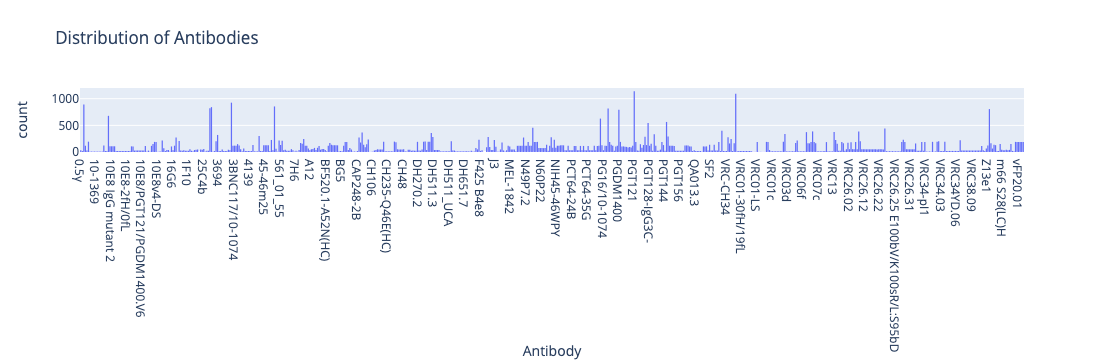

In [185]:
#Plotting the distribution of antibodies

fig = px.histogram(df_ic50, x="Antibody", title="Distribution of Antibodies")
fig.show()

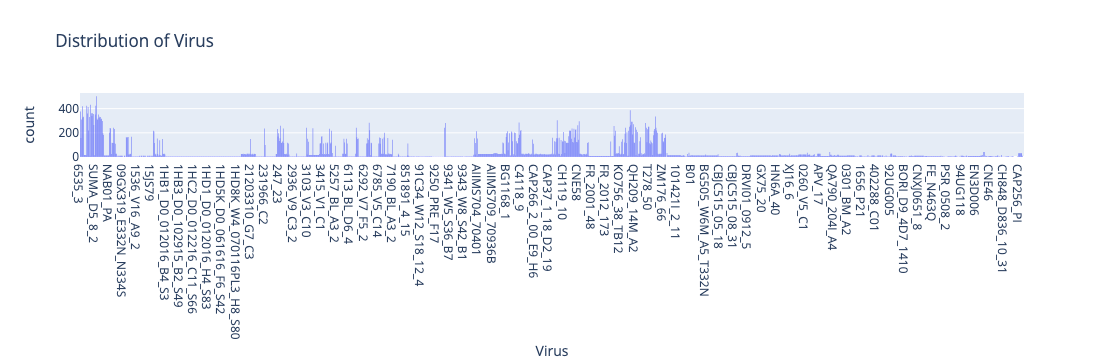

In [186]:
#Plotting the distribution of virus

fig = px.histogram(df_ic50, x="Virus", title="Distribution of Virus")
fig.show()

Because we have many antibodies that were tested against only a few virus, I decided to keep only the antibodies that were tested against at least 300 virus, so the model does not get imbalanced. Below, I am counting the number of virus tested per antibody.

In [187]:
# Creating a dataframe with antibody and virus

ab_virus = df_ic50[['Antibody', 'Virus']]
ab_virus.head()

Antibody      Virus
0     0.5γ     6535_3
1     0.5γ       89_6
2     0.5γ    AC10_29
3     0.5γ   CAAN5342
4     0.5γ  CAP210_E8

In [188]:
# Counting the number of virus per antibody

ab_group = ab_virus.groupby(by= ['Antibody']).count().sort_values(by = 'Virus', ascending = False)
ab_group = pd.DataFrame(ab_group).reset_index()
ab_group

Antibody  Virus
0            PGT121   1141
1             VRC01   1093
2           3BNC117    926
3           10-1074    893
4              4E10    855
..              ...    ...
609  VRC01-P63K(HC)      3
610  VRC01-N73T(LC)      3
611           HG107      2
612           HG120      2
613           246-D      1

[614 rows x 2 columns]

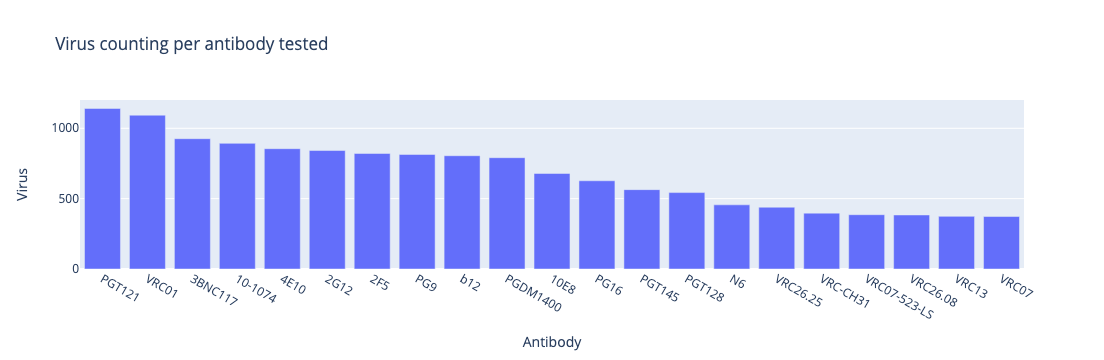

In [189]:
#Plotting the table with the top 21 antibodies based on the number of virues tested

fig = px.bar(ab_group.head(21), x="Antibody", y="Virus", title="Virus counting per antibody tested")
fig.show()

In [190]:
ab_group.columns

Index(['Antibody', 'Virus'], dtype='object')

I also wanted to group these antibodies by neutralization so I can decresase imbalance class for this feature.

In [191]:
%%R -i df_ic50 -w 900 -r 120
library("dplyr")
#library("ggplot2")
library("svglite")
# Set default theme
theme_set(theme_bw(base_family = "Liberation Sans"))
theme_set(theme_get() + theme(text=element_text(family = "Liberation Sans") ))

df_new_ab <- df_ic50 %>% 
    group_by( Antibody, Neutralization ) %>% 
    tally() %>% 
    group_by( Antibody ) %>% 
    mutate(
        total = sum(n)
    ) %>% 
    arrange(
        desc(total), 
        Antibody, 
        Neutralization, 
        desc(n)
    ) %>%
    ungroup() %>%
    top_n(40)

df_new_ab$Antibody <- factor(df_new_ab$Antibody , levels = unique(df_new_ab$Antibody))
df_new_ab$Neutralization <- factor(df_new_ab$Neutralization , levels = c(1,0))

ab_max = length(unique(df_new_ab$Antibody))
    
p <- ggplot(df_new_ab, aes(fill=Neutralization, y=n, x=Antibody)) + 
    geom_bar(position="stack", stat="identity", color='black', alpha = 0.8) + 
    ylab("Viruses") +
    theme_bw() +
    coord_cartesian( ylim=c(0,1200), xlim=c(1 -0.75, ab_max + 0.75), expand=F) +
    theme(
        axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
        plot.title = element_text(hjust = 0.5)
    )  +
    scale_fill_manual(values=c('1'='blue', '0'='red')) +
    ggtitle("Top 20 Antibodies in terms of numbers of viruses they were tested againt")

svg('barplot.svg', width = 8, height = 6 )
print(p)
invisible(dev.off())


Selecting by total


![Alt text](barplot.svg)

In [192]:
%%R
ab_neut_order <- df_new_ab %>% filter(Neutralization ==1) %>% arrange(desc(n)) %>% pull(Antibody)
df_new_ab_sort_neut <- df_new_ab 

df_new_ab_sort_neut$Antibody <- factor(df_new_ab_sort_neut$Antibody , levels = ab_neut_order)

ab_max = length(unique(df_new_ab_sort_neut$Antibody))
    
p <- ggplot(df_new_ab_sort_neut, aes(fill=Neutralization, y=n, x=Antibody)) + 
    geom_bar(position="stack", stat="identity", color='black', alpha = 0.8) + 
    ylab("Viruses") +
    theme_bw() +
    coord_cartesian( ylim=c(0,1200), xlim=c(1 -0.75, ab_max + 0.75), expand=F) +
    theme(
        axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
        plot.title = element_text(hjust = 0.5)
    )  +
    scale_fill_manual(values=c('1'='blue', '0'='red')) +
    ggtitle("Top 20 Antibodies sorted by Neutralization and number of viruses tested")

svg('barplot_sort_by_neut.svg', width = 8, height = 6 )
print(p)
invisible(dev.off())


![Alt text](barplot_sort_by_neut.svg)

In [193]:
%%R -i df_ic50 -w 1000 -h 800 -r 96
library("ggplot2")
# install.packages("dplyr")
library("dplyr") # Also needed
library("ggalluvial")
library("svglite")
# Set default theme
# Set default theme
theme_set(theme_bw(base_family = "Liberation Sans"))
theme_set(theme_get() + theme(text=element_text(family = "Liberation Sans") ))

# Change the settings
update_geom_defaults("text", list(colour = "grey20", family = theme_get()$text$family))

df <- df_new_ab
p <- ggplot(df, aes(y = n, axis1 = Antibody, axis2 = Neutralization)) +
  geom_alluvium(aes(fill = factor(Neutralization)),  aes.bind=TRUE, width = 1/10, alpha=0.7) +
  geom_stratum(width = 1/10, fill = "white", color = "black", alpha = 0.8) +
  geom_text(stat = "stratum", aes(label = after_stat(stratum)), size = 3) +
  scale_x_discrete(limits = c("Antibody","Neutralization"),
                   expand = c(.05, .05)) +
  scale_fill_manual(values = c("0" = "red", "1" = "blue")) +
  labs(y = "") +
  theme_minimal(base_size = 16) +
  theme(legend.position = "none", panel.grid = element_blank(), axis.text.y = element_blank()) +
  ggtitle("Antibodies vs Neutralization")
    
svg('alluvial.svg', width = 10, height = 8 )
print(p)
invisible(dev.off())
#p


In addition: Warning message:
In compute_panel(...) :
  Logical values of `aes.bind` are deprecated; replacing TRUE with 'flows'.


![Alt text](alluvial.svg)

In [194]:
df_new_ab = %R df_new_ab
df_new_ab

Antibody Neutralization     n  total
1         PGT121              0   772   1141
2         PGT121              1   369   1141
3          VRC01              0  1036   1093
4          VRC01              1    57   1093
5        3BNC117              0   634    926
6        3BNC117              1   292    926
7        10-1074              0   564    893
8        10-1074              1   329    893
9           4E10              0   848    855
10          4E10              1     7    855
11          2G12              0   841    842
12          2G12              1     1    842
13           2F5              0   815    821
14           2F5              1     6    821
15           PG9              0   680    814
16           PG9              1   134    814
17           b12              0   783    805
18           b12              1    22    805
19      PGDM1400              0   535    791
20      PGDM1400              1   256    791
21          10E8              0   641    679
22          10E8              1    38    679
23          PG16              0   495    627
24          PG16              1   132    627
25        PGT145              0   449    564
26        PGT145              1   115    564
27        PGT128              0   339    543
28        PGT128              1   204    543
29            N6              0   282    456
30            N6              1   174    456
31      VRC26.25              0   215    439
32      VRC26.25              1   224    439
33      VRC-CH31              0   356    397
34      VRC-CH31              1    41    397
35  VRC07-523-LS              0   229    386
36  VRC07-523-LS              1   157    386
37      VRC26.08              0   244    384
38      VRC26.08              1   140    384
39         VRC13              0   305    374
40         VRC13              1    69    374

Because the number of virus that the antibodies 4E10, 2F5 and 2G12 are so low, I am going to remove them to avoid imbalance.

In [195]:
# Dropping all the rows with the antibodies 4E10, 2F5 and 2G12 from our dataframe

df_drop_4e10 = df_ic50[df_ic50['Antibody'].str.contains('4E10') == False]

In [196]:
df_drop_2F5 = df_drop_4e10[df_drop_4e10['Antibody'].str.contains('2F5') == False]

In [197]:
df_drop_2G12 = df_drop_2F5[df_drop_2F5['Antibody'].str.contains('2G12') == False]

In [198]:
df_ic50.shape

(57312, 5)

In [199]:
df_drop_4e10.shape

(56457, 5)

In [200]:
df_drop_2F5.shape

(55636, 5)

In [201]:
df_drop_2G12.shape

(54794, 5)

In [202]:
df_drop_2G12['Antibody'].unique()

array(['0.5γ', '1-79', '10-1074', '10-1074-IgG3C-', '10-1074GM',
       '10-1074V', '10-1121', '10-1130', '10-1146', '10-1341', '10-1369',
       '10-259', '10-303', '10-410', '10-847', '10-996', '10A3', '10A37',
       '10E8', '10E8 IgG mutant 1', '10E8 IgG mutant 2',
       '10E8 IgG mutant 3', '10E8 IgG mutant 5', '10E8-0fH/0fL',
       '10E8-0fH/4fL', '10E8-10fH/10fL', '10E8-10fH/16fL',
       '10E8-10fH/4fL', '10E8-19fH/10fL', '10E8-19fH/16fL',
       '10E8-2fH/0fL', '10E8-2fH/10fL', '10E8-2fH/4fL', '10E8/N6',
       '10E8/PGDM1400/PRO-140', '10E8/PGT121/PGDM1400.V1',
       '10E8/PGT121/PGDM1400.V2', '10E8/PGT121/PGDM1400.V3',
       '10E8/PGT121/PGDM1400.V4', '10E8/PGT121/PGDM1400.V5',
       '10E8/PGT121/PGDM1400.V6', '10E8/PGT121/PGDM1400.V7',
       '10E8/PGT121/PGDM1400.V8', '10E8/PGT121/PGDM1400.V8.4DS',
       '10E8/PGT121/PGDM1400.V8Fc', '10E8/PGT121/PGDM1400.V8LL',
       '10E8V1.1/P140', '10E8V2.0/iMab', '10E8v4', '10E8v4-5R-100cF',
       '10E8v4-DS', '10J4', '10M6', '

In [203]:
# Dataframe to keep data only for the top 17 antibodies
df_sorted_ic50 = None
df_sorted_ic50 = df_drop_2G12.loc[df_drop_2G12['Antibody'].isin(df_new_ab['Antibody'])].sort_values(by = 'Antibody')
df_sorted_ic50 = df_sorted_ic50.reset_index(drop=True)
df_sorted_ic50

Antibody                 Binding Type             Virus  \
0      10-1074  gp120 V3 // V3 glycan (V3g)      0013095_2_11   
1      10-1074  gp120 V3 // V3 glycan (V3g)   AIIMS706_70607F   
2      10-1074  gp120 V3 // V3 glycan (V3g)   AIIMS709_70912B   
3      10-1074  gp120 V3 // V3 glycan (V3g)   AIIMS709_70915B   
4      10-1074  gp120 V3 // V3 glycan (V3g)  AIIMS709_709312B   
...        ...                          ...               ...   
11307      b12                  gp120 CD4bs    A03349M1_VRC4A   
11308      b12                  gp120 CD4bs    A07412M1_VRC12   
11309      b12                  gp120 CD4bs           AC10_29   
11310      b12                  gp120 CD4bs           92UG005   
11311      b12                  gp120 CD4bs          ZM55_28A   

                                                Sequence  Neutralization  
0      MRVKG-ILRNYQQW--------WIW--------SILGFW--MLMN-...               0  
1      MRVRG-IWRNYPQW--------WIW--------GVLG-----LLI-...               1  
2      MRVRG-TLRNYQQW--------WIW--------GILGFW--MLMI-...               0  
3      MRVMG-ILRNWQQW--------WIW--------GILGFW--MLMI-...               0  
4      MRVRG-TLRNYQQW--------WIW--------GILGFW--MLMI-...               0  
...                                                  ...             ...  
11307  MRVRG-IQRNYQNL--------WRW--------GTLLLG--MLMI-...               0  
11308  VRVKE-TVRNYQHL--------WRW--------GIMLLG--MLMI-...               0  
11309  MRVRE-TRKNYQHLW-------WKW--------GMMLLG--MLMI-...               0  
11310  MRVRG-IQRNYQHL--------WKW--------GTMLLW--ILMT-...               0  
11311  MRVKG-MKRNWQQW--------WIW--------GILGFW--ML---...               0  

[11312 rows x 5 columns]

In [204]:
df_sorted_ic50['Antibody'].unique()

array(['10-1074', '10E8', '3BNC117', 'N6', 'PG16', 'PG9', 'PGDM1400',
       'PGT121', 'PGT128', 'PGT145', 'VRC-CH31', 'VRC01', 'VRC07-523-LS',
       'VRC13', 'VRC26.08', 'VRC26.25', 'b12'], dtype=object)

In [205]:
#counting the number of unique sequences of virus we have left 

unique_sequences_sort = len(np.unique(df_sorted_ic50["Sequence"]))
print("Number of Unique Sequences:", unique_sequences_sort)


Number of Unique Sequences: 1395


In total we ended up with 17 antibodies for our analysis. The number of unique virus/ sequences was 1423 and now is 1395.

In [ ]:
#Generate final dataframe to load for the models
df_sorted_ic50.to_csv('df_ic50_final.csv')